In [2]:
# NOTEBOOK IMPORTS
import os
import glob
import numpy as np
from tqdm.notebook import tqdm
from shutil import copyfile

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona
import pyproj
from affine import Affine
from shapely.geometry import shape, mapping
from shapely.geometry import Point, LineString
from shapely.ops import transform, nearest_points, snap
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *

Image.MAX_IMAGE_PIXELS = 933120000

In [3]:
templates_dir = "data/templates/"
tempfiles_dir = "tempfiles/"

boundary_shapefile = f"{templates_dir}HCAD_Harris_County_Boundary.shp"
boundary_points    = f'{tempfiles_dir}boundary_points.shp'
roads_points       = f'{tempfiles_dir}roads_points.shp'

tile_file = f"data/TileIndices/48201CIND0_0992.tif"

roads_fn = f"data/Roads/TexasHighways.shp"

In [4]:
line = fiona.open(boundary_shapefile)

firstline = line.next()
first = shape(firstline['geometry']).boundary

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:3857')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
first = transform(project, first)

# length of the LineString
length = first.length

point_boundary_list = list()

if not os.path.exists(boundary_points):
    for distance in tqdm(range(0,int(length),20)):
        point = first.interpolate(distance)   
        point_boundary_list.append(point)
    point_boundary_gdf = gpd.GeoDataFrame(geometry=point_boundary_list)
    point_boundary_gdf.to_file(boundary_points)
    

C:\Users\franc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
boundary_shp = gpd.read_file(boundary_shapefile).to_crs("EPSG:3857")

roads = gpd.read_file(roads_fn).to_crs("EPSG:3857")
roads = gpd.clip(roads, boundary_shp)

In [6]:
if not os.path.exists(roads_points):
    point_list = list()
    for index, row in tqdm(roads.iterrows(), total=roads.shape[0]):
        linestring = row['geometry']
        for distance in range(0,int(length),20):
            point = linestring.interpolate(distance)   
            point_list.append(point)
    point_roads_gdf = gpd.GeoDataFrame(geometry=point_list)
    point_roads_gdf.to_file(roads_points)

In [65]:
def preprocess_roads(image, radius=5, threshold_value=50, erode_num=3):
    
    # 0 TO 255
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (radius, radius), 0)
    # Threshold the image
    _, thresholded_image = cv2.threshold(blurred_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    # DILATE
    thresholded_image = cv2.erode(thresholded_image, np.ones((3,3), np.uint8), iterations=erode_num)
    
    # EDGES
    edges = cv2.Canny(thresholded_image, 50, 100)
    
    return edges, thresholded_image

In [37]:
# BOUNDARY SHAPEFILE AND BUFFER
boundary_shp = gpd.read_file(boundary_shapefile).to_crs("EPSG:3857")
boundary_buf = boundary_shp.boundary.buffer(5000)

roads_shp = gpd.read_file(roads_fn).to_crs("EPSG:3857")
roads_shp = gpd.clip(roads_shp, boundary_shp)
roads_buff = roads_shp.geometry.buffer(500)
roads_buff = gpd.GeoDataFrame(geometry=roads_buff).dissolve()

<AxesSubplot:>

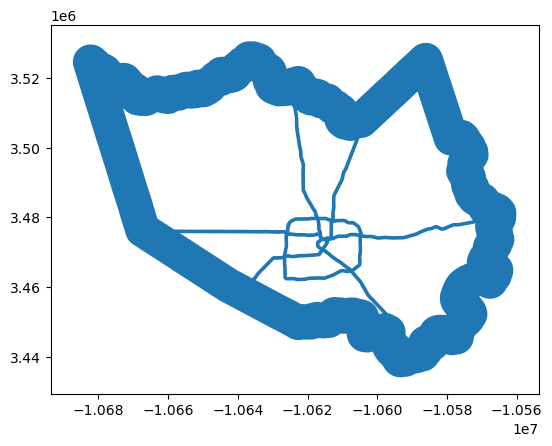

In [39]:
fig, ax = plt.subplots()
roads_shp.plot(ax=ax)
roads_buff.plot(ax=ax)
boundary_buf.plot(ax=ax)

In [77]:
# BOUNDARY POINTS 
boundary_points_gdf_or = gpd.read_file(boundary_points)
boundary_coords_or = np.vstack((boundary_points_gdf_or.geometry.x.to_numpy(), boundary_points_gdf_or.geometry.y.to_numpy())).T

# ROADS POINTS 
roads_points_gdf_or = gpd.read_file(roads_points)
roads_coords_or = np.vstack((roads_points_gdf_or.geometry.x.to_numpy(), roads_points_gdf_or.geometry.y.to_numpy())).T

In [158]:
# INITIALIZE VARIABLES
initial_filename = f"{tempfiles_dir}border.png"
current_filename = initial_filename
current_tilefile = tile_file
roads_prep_args = {"radius":5, "threshold_value":50, "erode_num":3}

for i in range(10):
    print(i)
    output_filename = f"{tempfiles_dir}/out/border_{i}.png"
    tile_filename = f"{tempfiles_dir}/out/tile_{i}.png"
    
    # GET ORIGINAL TRANSFORM FROM IMAGE AND CONVERT TO AFFINE OBJECT
    print("Original Transform")
    original_transform, _ = get_geotransform_from_tfw(current_filename[:-3]+"pgw")
    ot = Affine.from_gdal(*original_transform)
    
    # CANDIDATE PIXEL (KEYPOINT) COORDINATES FROM TILE
    print("Points from Image (Border)")
    rows, cols = get_true_pixel_rc(current_filename, polygon=boundary_buf)
    image_coords_arry = np.vstack((rows, cols)).T
    
    print("Points from Image (Roads)")
    rows_roads, cols_roads = get_true_pixel_rc(current_tilefile, 
                                               polygon=roads_buff, 
                                               preprocess=preprocess_roads,
                                               prep_args=roads_prep_args
                                              )
    image_coords_arry_roads = np.vstack((rows_roads, cols_roads)).T
    # PIXEL COORDINATES FROM CLOSEST POINT IN LINE, NORMALIZED TO INVERSE TRANSFORM OF SHAPEFILE
    print("Points from boundary")
    # point_boundary_gdf = boundary_points_gdf_or.copy()
    # point_boundary_gdf = normalize_geometry(point_boundary_gdf, ot)
    # boundary_coords = np.vstack((point_boundary_gdf.geometry.x.to_numpy(), point_boundary_gdf.geometry.y.to_numpy())).T
    boundary_coords = normalize_geometry_opt(boundary_coords_or, ot)
    kdtree = cKDTree(boundary_coords)
    
    print("Points from roads")
    # point_roads_gdf = roads_points_gdf_or.copy()
    # point_roads_gdf = normalize_geometry(point_roads_gdf, ot)
    # roads_coords = np.vstack((point_roads_gdf.geometry.x.to_numpy(), point_roads_gdf.geometry.y.to_numpy())).T
    roads_coords = normalize_geometry_opt(roads_coords_or, ot)
    kdtree_roads = cKDTree(roads_coords)
    
    print("Starting matching")
    _, nearest_indices = kdtree.query(image_coords_arry)
    boundary_points_matching = [boundary_coords[idx] for idx in nearest_indices]
    
    _, nearest_indices = kdtree_roads.query(image_coords_arry_roads)
    roads_points_matching = [roads_coords[idx] for idx in nearest_indices]
    
    print("matched")
    # COORDINATE ARRAY
    boundary_points_matching_coords = boundary_points_matching
    roads_points_matching_coords = roads_points_matching
    boundary_points_matching_coords.extend(roads_points_matching_coords)
    matching_coords = np.array(boundary_points_matching_coords)
        
    # TO AND FROM POINTS
    print("To/From")
    to_points = np.array(matching_coords).astype(np.float32)  
    from_points = np.vstack((image_coords_arry, image_coords_arry_roads))    
    
    # CALCULATE HOMOGRAPHY
    print("Homography")
    output = cv2.findHomography(from_points, to_points, cv2.RANSAC, 1000)
    homography = output[0]
    print(homography)
    
    # GET CURRENT TRANSFORM
    print("Calculate Transform")
    original_transform, _ = get_geotransform_from_tfw(current_filename[:-3]+"pgw")
    current_transform = getActualTransform(original_transform, homography.flatten()[:6], ) # scale=(4/5)**i
    
    # OUTPUT
    print("Save")
    copyfile(current_filename, output_filename)
    copyfile(tile_file, tile_filename)
    write_world_file_from_affine(current_transform, output_filename[:-3]+"pgw")
    write_world_file_from_affine(current_transform, tile_filename[:-3]+"pgw")
    current_filename = output_filename
    current_tilefile = tile_filename
    error

0
Original Transform
Points from Image (Border)
Points from Image (Roads)
Points from boundary
Points from roads
Starting matching
matched
To/From
Homography
[[ 1.01798532e+00  1.13783591e-02 -8.34826257e+01]
 [ 8.44281577e-03  1.00743665e+00 -3.06792193e+01]
 [ 1.47547141e-06  6.58021623e-07  1.00000000e+00]]
Calculate Transform
Save


NameError: name 'error' is not defined

In [76]:
len(points_matching)

NameError: name 'points_matching' is not defined

In [ ]:
fig, ax = plt.subplots()
ax.scatter(image_coords_arry_roads[:, 0], image_coords_arry_roads[:, 1], s=1)
ax.scatter(roads_coords[:, 0], roads_coords[:, 1], s=1)

In [ ]:
image_coords_arry_roads.shape

In [ ]:
cv2.findHomography(from_points, to_points, cv2.RANSAC, 10000000)

In [ ]:
tile_img = cv2.imread(tile_file)

In [ ]:
test = preprocess_roads(tile_img, 5, 90)
cv2.imwrite(f"{tempfiles_dir}/test.png", test)